In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import spacy
from spacy.lang.en.stop_words import stopword
from spacy.lang.en import English
import re
import string

In [2]:
df=pd.read_csv("./fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
df.shape

(17880, 18)

In [4]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [5]:
df.drop(columns=["job_id","telecommuting","salary_range","employment_type","has_company_logo"],inplace=True)

In [6]:
df.fillna("",inplace=True)

<AxesSubplot: xlabel='count', ylabel='fraudulent'>

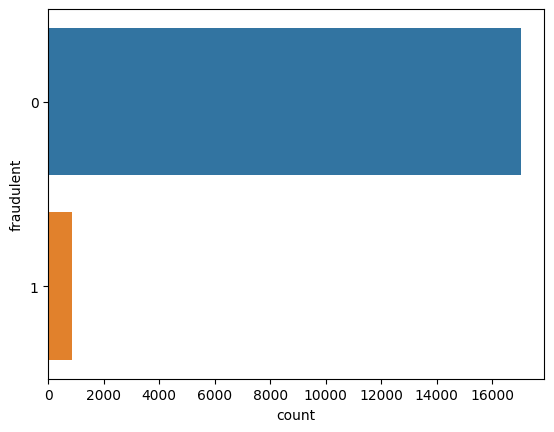

In [7]:
sns.countplot(y="fraudulent",data=df)

In [8]:
df.groupby("fraudulent")["fraudulent"].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

In [9]:
exp=dict(df.required_experience.value_counts())

In [10]:
del exp[""]

In [11]:
exp

{'Mid-Senior level': 3809,
 'Entry level': 2697,
 'Associate': 2297,
 'Not Applicable': 1116,
 'Director': 389,
 'Internship': 381,
 'Executive': 141}

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Mid-Senior level'),
  Text(1, 0, 'Entry level'),
  Text(2, 0, 'Associate'),
  Text(3, 0, 'Not Applicable'),
  Text(4, 0, 'Director'),
  Text(5, 0, 'Internship'),
  Text(6, 0, 'Executive')])

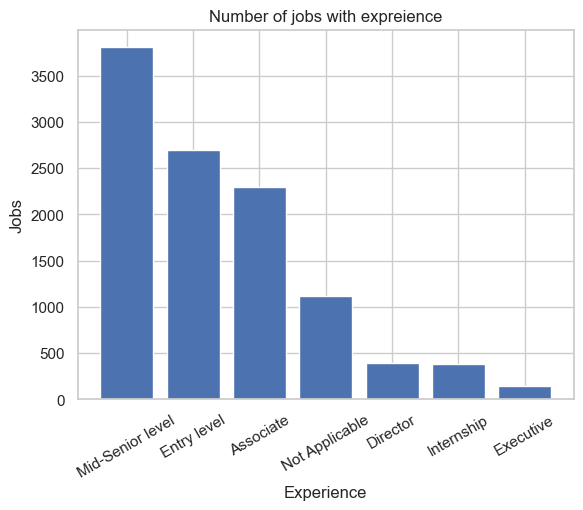

In [12]:
sns.set_theme(style="whitegrid")
plt.title("Number of jobs with expreience")
plt.bar(exp.keys(),exp.values())
plt.xlabel("Experience")
plt.ylabel("Jobs")
plt.xticks(rotation=30)

In [13]:
df["Country"]=df["location"].apply(lambda x : x.split(",")[0])
df.head()

,title,location,department,company_profile,description,requirements,benefits,has_questions,required_experience,required_education,industry,function,fraudulent,Country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,1,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [14]:
Country=dict(df.Country.value_counts()[:15])
del Country[""]
Country

{'US': 10656,
 'GB': 2384,
 'GR': 940,
 'CA': 457,
 'DE': 383,
 'NZ': 333,
 'IN': 276,
 'AU': 214,
 'PH': 132,
 'NL': 127,
 'BE': 117,
 'IE': 114,
 'SG': 80,
 'HK': 77}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'US'),
  Text(1, 0, 'GB'),
  Text(2, 0, 'GR'),
  Text(3, 0, 'CA'),
  Text(4, 0, 'DE'),
  Text(5, 0, 'NZ'),
  Text(6, 0, 'IN'),
  Text(7, 0, 'AU'),
  Text(8, 0, 'PH'),
  Text(9, 0, 'NL'),
  Text(10, 0, 'BE'),
  Text(11, 0, 'IE'),
  Text(12, 0, 'SG'),
  Text(13, 0, 'HK')])

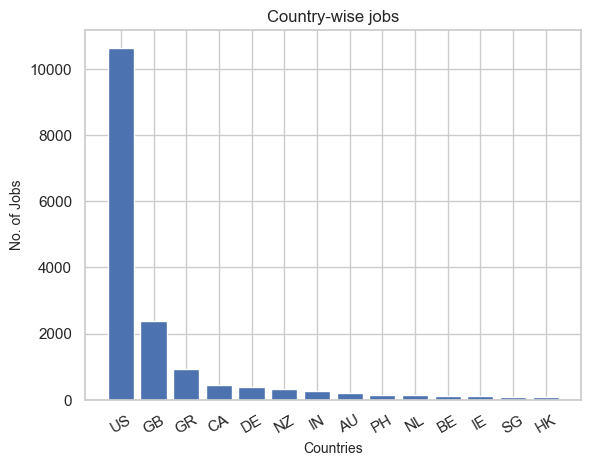

In [15]:
sns.set_theme(style="whitegrid")
plt.title("Country-wise jobs")
plt.bar(Country.keys(),Country.values())
plt.xlabel("Countries",size=10)
plt.ylabel("No. of Jobs",size=10)
plt.xticks(rotation=30)

In [16]:
education=dict(df.required_education.value_counts()[:8])
del education[""]
education

{"Bachelor's Degree": 5145,
 'High School or equivalent': 2080,
 'Unspecified': 1397,
 "Master's Degree": 416,
 'Associate Degree': 274,
 'Certification': 170,
 'Some College Coursework Completed': 102}

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, "Bachelor's Degree"),
  Text(1, 0, 'High School or equivalent'),
  Text(2, 0, 'Unspecified'),
  Text(3, 0, "Master's Degree"),
  Text(4, 0, 'Associate Degree'),
  Text(5, 0, 'Certification'),
  Text(6, 0, 'Some College Coursework Completed')])

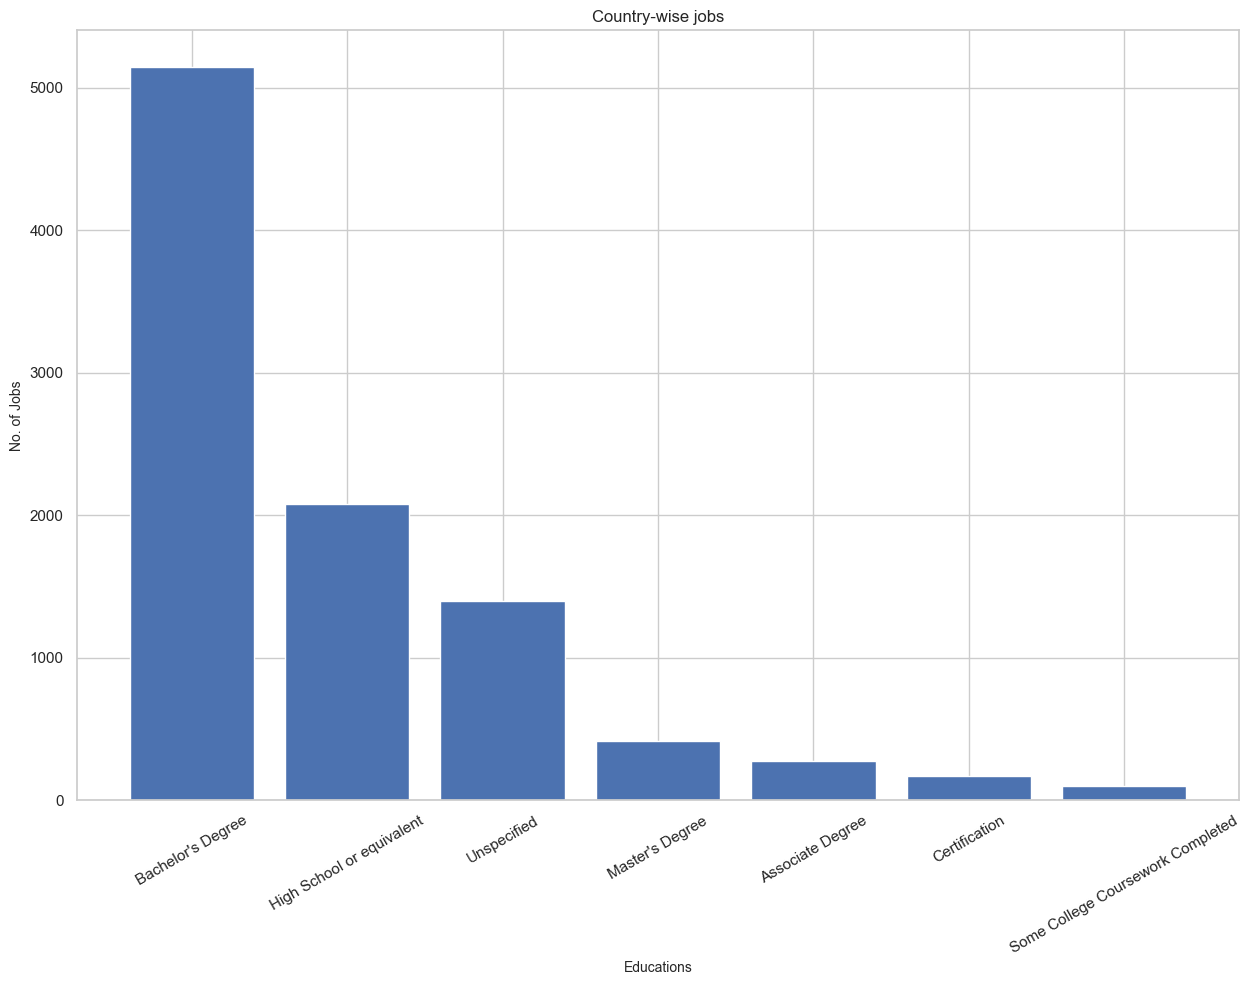

In [17]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,10))
plt.title("Country-wise jobs")
plt.bar(education.keys(),education.values())
plt.xlabel("Educations",size=10)
plt.ylabel("No. of Jobs",size=10)
plt.xticks(rotation=30)

In [18]:
print(df[df.fraudulent==0].title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [19]:
print(df[df.fraudulent==1].title.value_counts()[:10])


Data Entry Admin/Clerical Positions - Work From Home                    21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Cruise Staff Wanted *URGENT*                                            21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Network Marketing                                                       10
Payroll Clerk                                                           10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Name: title, dtype: int64


In [20]:
df["text"]=df["title"]+" "+df["company_profile"]+" "+df["description"]+" "+df["requirements"]+" "+df["benefits"]


In [21]:
df.drop(columns=["title","location","department","company_profile","description","requirements","benefits","required_experience","required_education","industry","function","Country"],inplace=True)

In [22]:
del df["has_questions"]

In [23]:
df

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've creat..."
1,0,Customer Service - Cloud Video Production 90 S...
2,0,Commissioning Machinery Assistant (CMA) Valor ...
3,0,Account Executive - Washington DC Our passion ...
4,0,Bill Review Manager SpotSource Solutions LLC i...
...,...,...
17875,0,Account Director - Distribution Vend is looki...
17876,0,Payroll Accountant WebLinc is the e-commerce p...
17877,0,Project Cost Control Staff Engineer - Cost Con...
17878,0,Graphic Designer Nemsia Studios is looking fo...


In [24]:
realjobs=df[df.fraudulent==0].text

In [25]:
fakejobs=df[df.fraudulent==1].text
fakejobs

98       IC&E Technician                               ...
144      Forward Cap.  The group has raised a fund for ...
173      Technician Instrument & Controls  Edison Inter...
180      Sales Executive  Sales Executive Sales Executi...
215      IC&E Technician Mt Poso                       ...
                               ...                        
17827    Student Positions Part-Time and Full-Time.  St...
17828    Sales Associate  LEARN TO EARN AN EXECUTIVE LE...
17829    Android Developer  inFullMobile Sp. z o.o. is ...
17830    Payroll Clerk   JOB DESCRIPTIONWe are seeking ...
17831    Furniture mover Anthony Warren is a Marketing ...
Name: text, Length: 866, dtype: object

In [26]:
stopwords=spacy.lang.en.stop_words.STOP_WORDS
len(stopwords)

326

In [27]:
from wordcloud import WordCloud
wc=WordCloud(min_font_size=3,max_words=3000,width=1600,height=800,stopwords=stopwords).generate(str(" ".join(fakejobs)))

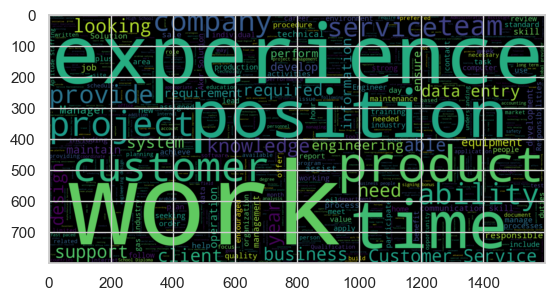

In [28]:
plt.imshow(wc,interpolation="bilinear")

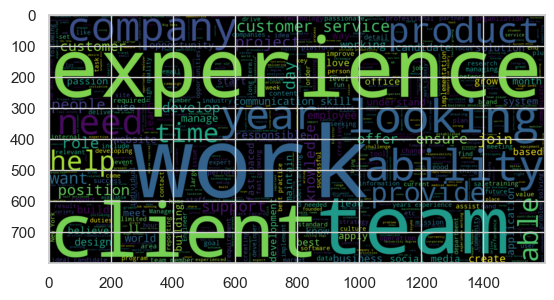

In [29]:
stopwords=spacy.lang.en.stop_words.STOP_WORDS
# from wordcloud import WordCloud
wc=WordCloud(min_font_size=3,max_words=3000,width=1600,height=800,stopwords=stopwords).generate(str(" ".join(realjobs)))
plt.imshow(wc,interpolation="bilinear")

In [30]:
punction=string.punctuation
nlp=spacy.load("en_core_web_sm")
stop_words=spacy.lang.en.stop_words.STOP_WORDS
parser=English()
def spacy_tok(sent):
    mytok=parser(sent)
    mytok=[word.lemma_.lower().strip() if word.lemma_ !="-PRON-" else word.lemma_ for word in mytok]
    mytok=[word for word in mytok if word not in stop_words and word not in punction]
    return mytok

class predictors(TransformerMixin):
    def transform(self,X,**transform_params):
        return [clean_text(text) for text in X]
    def fit(self,X,**transform_params):
        return self
    def get_params(self,deep=True):
        return {}
    
def clean_text(text):
    return text.strip().lower()

In [31]:
df["text"]=df["text"].apply(clean_text)

In [32]:
cv=TfidfVectorizer(max_features=100)
x=cv.fit_transform(df["text"])
df1=pd.DataFrame(x.toarray(),columns=cv.get_feature_names())
df.drop(["text"],axis=1,inplace=True)
main=pd.concat([df1,df],axis=1)

c:\Users\Arash\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [33]:
main

,ability,about,all,also,amp,an,and,are,as,at,...,who,will,with,work,working,world,years,you,your,fraudulent
0,0.000000,0.041120,0.000000,0.042424,0.036488,0.000000,0.755238,0.000000,0.078653,0.000000,...,0.000000,0.000000,0.186067,0.051026,0.068029,0.000000,0.000000,0.000000,0.000000,0
1,0.021895,0.094183,0.035394,0.024292,0.041787,0.029771,0.490896,0.056626,0.060050,0.052431,...,0.000000,0.078004,0.165735,0.043827,0.116862,0.099327,0.000000,0.204854,0.130452,0
2,0.000000,0.000000,0.176807,0.000000,0.041749,0.089231,0.397029,0.113149,0.000000,0.000000,...,0.000000,0.062346,0.307512,0.058383,0.000000,0.000000,0.000000,0.094462,0.074476,0
3,0.023267,0.000000,0.018806,0.000000,0.000000,0.094909,0.695542,0.000000,0.031906,0.037144,...,0.023132,0.049735,0.075480,0.046573,0.000000,0.105551,0.019806,0.050236,0.059411,0
4,0.000000,0.000000,0.068009,0.000000,0.040147,0.028602,0.606379,0.081605,0.115386,0.000000,...,0.000000,0.000000,0.159230,0.028071,0.037425,0.000000,0.035814,0.030279,0.107427,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.019816,0.021310,0.080081,0.043970,0.075638,0.040415,0.423122,0.038437,0.013587,0.094904,...,0.059102,0.028239,0.171424,0.158660,0.123392,0.044947,0.000000,0.328016,0.101197,0
17876,0.058329,0.062728,0.094292,0.032358,0.083493,0.019828,0.591619,0.037714,0.000000,0.069840,...,0.000000,0.041562,0.204997,0.116759,0.000000,0.000000,0.049654,0.062971,0.049648,0
17877,0.043011,0.046255,0.000000,0.000000,0.000000,0.029242,0.528094,0.111240,0.058983,0.034333,...,0.000000,0.061294,0.093023,0.057398,0.038262,0.000000,0.073229,0.123824,0.073219,0
17878,0.000000,0.000000,0.061889,0.000000,0.146136,0.052057,0.449624,0.049508,0.000000,0.061120,...,0.076126,0.272793,0.082800,0.051090,0.068115,0.000000,0.000000,0.165325,0.130346,0


In [34]:
y=main.iloc[:,-1]
x=main.iloc[:,:-1]


In [35]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

In [52]:
from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC as SVM
rfc=DecisionTreeClassifier(random_state=0)
rfc.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

In [53]:
y_pred=rfc.predict(x_test)

In [54]:
accuracy_score(y_test,y_pred)

0.9554436987322893

In [55]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5111
           1       0.53      0.53      0.53       253

    accuracy                           0.96      5364
   macro avg       0.75      0.75      0.75      5364
weighted avg       0.96      0.96      0.96      5364



In [40]:
print(confusion_matrix(y_test,y_pred))

[[5109    2]
 [ 156   97]]
